In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

df = pd.read_csv('adult.data.csv', header=None, names = col_names)

The dataset has been loaded for you in script.py and saved as a dataframe named df. Some of the input and output features of interest are:

-`age`: continuous  
-`workclass`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.  
-`education`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th,   -Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool  
-`race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black  
-`sex`: Female, Male  
-`capital-gain`: continuous  
-`capital-loss`: continuous  
-`hours-per-week`: continuous  
-`native country`: discrete  
-`income`: discrete, >50K, <=50K  

In [113]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [114]:
#Distribution of income
df['income'].value_counts(normalize=True)

income
 <=50K    0.75919
 >50K     0.24081
Name: proportion, dtype: float64

In [115]:
#Clean columns by stripping extra whitespace for columns of type "object"

# Create list of columns that are objects
object_columns_list = df.select_dtypes(include=['object']).columns.tolist()

# Iterate through columns list and strip whitespace
for column in object_columns_list:
    df[column] = df[column].str.strip()

In [116]:
#Create feature dataframe X with feature columns and dummy variables for categorical features

# List of features to one hot encode
ohe_features = ['workclass', 'education', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'native-country']

# One Hot Encode Categorical Columns that are objects
ohe = pd.get_dummies(df[ohe_features], drop_first=True)

# Create list of columns to drop and add income to list
columns_to_drop = ohe_features
columns_to_drop.append('income')

# Remove categorical features for later joining with ohe
df_no_categorical = df.drop(columns = columns_to_drop)

# Create Matrix X by joining df_no_categorical and ohe
X = df_no_categorical.join(ohe)

#Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greater than 50k
y = np.where((df['income'] == '<=50K'), 0, 1) 

#Split data into a train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

In [117]:
#Instantiate random forest classifier, fit and score with default parameters
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

# Score model
rf_score = rf.score(x_test, y_test)
print(f'Baseline accuracy score: {rf_score}')

Baseline accuracy score: 0.861200675571933


In [118]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set

# Create empty lists for scores
accuracy_train = []
accuracy_test = []

# Iterate through depths between 1 and 25 and append scores to lists
for depth in range(1,26):
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(x_train, y_train)
    accuracy_train.append(rf.score(x_train, y_train))
    accuracy_test.append(rf.score(x_test, y_test))

In [119]:
# Find the largest accuracy and the depth this occurs on the test data.
largest_accuracy = max(accuracy_test)
best_depth = accuracy_test.index(largest_accuracy) + 1 # +1 account for index starting at 0

print(f'The largest accuracy is {largest_accuracy} and it occurs at depth {best_depth}')

The largest accuracy is 0.866421004145555 and it occurs at depth 22


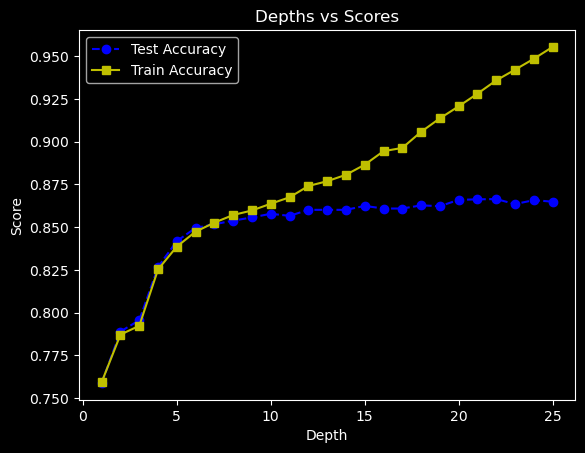

In [120]:
# Plot the training and test accuracy of the models versus the max_depth
x_depths = [x for x in range(1, 26)]

plt.plot(x_depths, accuracy_test, 'bo--')
plt.plot(x_depths, accuracy_train, 'ys-')
plt.legend(['Test Accuracy', 'Train Accuracy'])
plt.title('Depths vs Scores')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.show()

In [121]:
# Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)

# Fit the data
best_rf.fit(x_train, y_train)

# Extract feature names and importances to lists
feature_names = best_rf.feature_names_in_.tolist()
feature_importances = best_rf.feature_importances_.tolist()

# Create dataframe of feature names and importances
feature_df = pd.DataFrame(data={'feature_names':feature_names, 
                                'feature_importances':feature_importances})

# Sort dataframe by descending order of importances
feature_df.sort_values('feature_importances', 
                       ascending=False, 
                       ignore_index=True).head(5)


,feature_names,feature_importances
0,capital-gain,0.132710
1,marital-status_Married-civ-spouse,0.122411
2,age,0.103666
3,education-num,0.093020
4,fnlwgt,0.079189


In [136]:
# Create list of education values
education_values = df['education-num'].unique().tolist()

'''
Bin education levels into 3 bins: "Masters and more," "College to Bachelors," 
"High school and less"
'''

# Create function to bin values
def edu_bin(x):
    if x <= 16 and x > 13:
        return 'Masters and more'
    elif x <= 13 and x > 9:
        return 'College to Bachelors'
    elif x <= 9:
        return 'High school and less'
    else:
        return 'NaN'

# create new binned feature        
df['education_bin'] = df['education-num'].apply(edu_bin)

# Re-Create feature dataframe X with feature columns and dummy variables for categorical features
# List of features to one hot encode
ohe_features2 = ['workclass', 'education_bin', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'native-country']

# One Hot Encode Categorical Columns that are objects
ohe2 = pd.get_dummies(df[ohe_features2], drop_first=True)

# Create list of columns to drop and add income to list
columns_to_drop2 = ohe_features2
additional_columns_to_drop = ['income', 'education', 'education-num']

# add additional columns to drop to main drop list
for column in additional_columns_to_drop:
    columns_to_drop2.append(column)

# Remove categorical features for later joining with ohe
df_no_categorical2 = df.drop(columns = columns_to_drop2)

# Create Matrix X by joining df_no_categorical and ohe
X2 = df_no_categorical2.join(ohe2)

#Split data into a train and test set
x_train, x_test, y_train, y_test = train_test_split(X2, y, random_state=42, test_size=0.20)

In [137]:
#  Fit a random forest classifier for max_depth values from 1-25

# Create empty lists for scores
accuracy_train = []
accuracy_test = []

# Iterate through depths between 1 and 25 and append scores to lists
for depth in range(1,26):
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(x_train, y_train)
    accuracy_train.append(rf.score(x_train, y_train))
    accuracy_test.append(rf.score(x_test, y_test))

In [138]:
# Find the largest accuracy and the depth this occurs on the test data.
largest_accuracy = max(accuracy_test)
best_depth = accuracy_test.index(largest_accuracy) + 1 # +1 account for index starting at 0

print(f'The largest accuracy is {largest_accuracy} and it occurs at depth {best_depth}')

The largest accuracy is 0.8705665591893137 and it occurs at depth 20


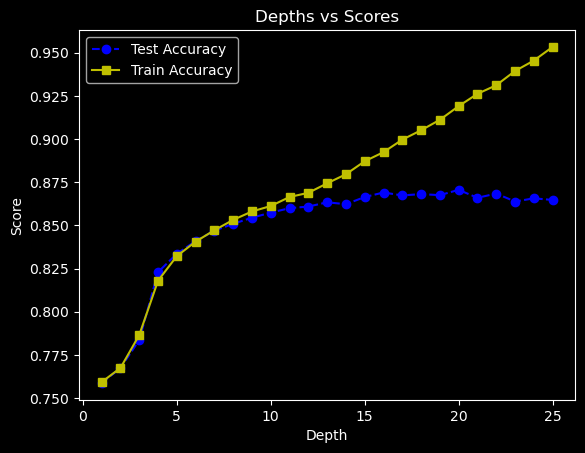

In [139]:
# Plot the training and test accuracy of the models versus the max_depth
x_depths = [x for x in range(1, 26)]

plt.plot(x_depths, accuracy_test, 'bo--')
plt.plot(x_depths, accuracy_train, 'ys-')
plt.legend(['Test Accuracy', 'Train Accuracy'])
plt.title('Depths vs Scores')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.show()

In [140]:
# Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)

# Fit the data
best_rf.fit(x_train, y_train)

# Extract feature names and importances to lists
feature_names = best_rf.feature_names_in_.tolist()
feature_importances = best_rf.feature_importances_.tolist()

# Create dataframe of feature names and importances
feature_df = pd.DataFrame(data={'feature_names':feature_names, 
                                'feature_importances':feature_importances})

# Sort dataframe by descending order of importances
feature_df.sort_values('feature_importances', 
                       ascending=False, 
                       ignore_index=True).head(5)

,feature_names,feature_importances
0,capital-gain,0.146633
1,marital-status_Married-civ-spouse,0.136684
2,age,0.104164
3,fnlwgt,0.073085
4,hours-per-week,0.068652
